In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")

from cln import contamination
from third_party import arc

In [49]:
# Define default parameters
n_train = 5000
n_cal = 1000
estimate = "none"
seed = 1

# Define other constant parameters
n_test = 2000
batch_size = 20

In [50]:
num_var = 2
K = 4
signal = 1.0
n_informative=2
n_redundant=0
n_clusters_per_class=1

In [51]:
# Generate a large data set
X, Y = make_classification(n_samples=n_train+n_cal,
                                    n_classes=K,
                                    n_features=num_var,
                                    n_informative=2,
                                    n_redundant=0,
                                    n_clusters_per_class=1,
                                    class_sep=signal)

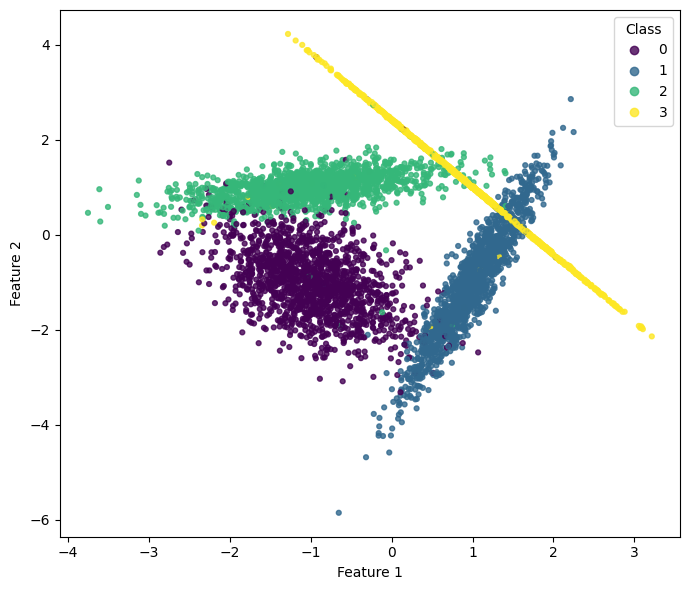

In [52]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=Y, s=12, alpha=0.8)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Add legend with unique class labels
handles, _ = scatter.legend_elements()
plt.legend(handles, np.unique(Y), title="Class")

plt.tight_layout()
plt.show()

In [53]:
"""
# Manual construction of T
T = np.identity(K)
T[1,1] = 0.7
T[2,1] = 0.15
T[0,1] = 0.15

T[K-2,K-2] = 0.7
T[K-3,K-2] = 0.15
T[K-1,K-2] = 0.15
"""

'\n# Manual construction of T\nT = np.identity(K)\nT[1,1] = 0.7\nT[2,1] = 0.15\nT[0,1] = 0.15\n\nT[K-2,K-2] = 0.7\nT[K-3,K-2] = 0.15\nT[K-1,K-2] = 0.15\n'

In [54]:
epsilon = 0.2
T = (1-epsilon) * np.identity(K) + epsilon/K * np.ones((K,K))

In [55]:
# Generate the contaminated labels
contamination_process = contamination.LinearContaminationModel(T)
Yt = contamination_process.sample_labels(Y)

In [56]:
# Separate the training e calibration set
X_train, X_cal, Y_train, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal)

In [57]:
X_cal.shape[0]

1000

In [10]:
# training del point predictor
model_name = 'RFC'
# Initialize black-box model
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

black_box_pt = copy.deepcopy(black_box)
black_box_pt.fit(X_train, Yt_train)

In [11]:
# Estimate the label contamination process using anchor points
p_hat_cal = black_box_pt.predict_proba(X_cal)
if not isinstance(p_hat_cal, np.ndarray):
    p_hat_cal = np.asarray(p_hat_cal)
_, K_out = p_hat_cal.shape
assert K_out == K, f"black_box_pt returned {K_out} classes, expected {K}"

gamma = 0.03
m03 = max(1, int(np.ceil(gamma * n_cal)))

gamma = 0.1
m1 = max(1, int(np.ceil(gamma * n_cal)))

T_hat_top3ap = np.zeros((K, K), dtype=float)
T_hat_hybrid = np.zeros((K, K), dtype=float)

A_indices_list = []

for l in range(K):
    scores_l = p_hat_cal[:, l]
    top_idx_03 = np.argsort(scores_l)[::-1][:m03]
    # Average the predicted probability vectors over these top examples
    col_T_hat = p_hat_cal[top_idx_03, :].mean(axis=0)
    T_hat_top3ap[:, l] = col_T_hat/np.sum(col_T_hat)

    top_idx_1 = np.argsort(scores_l)[::-1][:m1]
    n_l_top = len(top_idx_1)
    if n_l_top > 0:
        counts = np.bincount(Yt_cal[top_idx_1], minlength=K)
        T_hat_hybrid[:,l] = counts/n_l_top

    A_indices_list.append(top_idx_03)

In [12]:
true_labels_per_class = []

for l in range(K):
    idx = A_indices_list[l]
    true_labels = Y_cal[idx]
    true_labels_per_class.append(true_labels)

In [13]:
for l in range(K):
    print(f"Class {l}: true labels = {true_labels_per_class[l]}")

Class 0: true labels = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
Class 1: true labels = [1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1]
Class 2: true labels = [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2]
Class 3: true labels = [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


Estimate the contamination process using clean labels

In [14]:
# Estimate the contamination process using clean labels
_, Y_train2 = make_classification(n_samples=100,
                                    n_classes=K,
                                    n_features=num_var,
                                    n_informative=2,
                                    n_redundant=0,
                                    n_clusters_per_class=1,
                                    class_sep=signal)
contamination_process = contamination.LinearContaminationModel(T)
Yt_train2 = contamination_process.sample_labels(Y_train2)

T_hat_100 = np.zeros((K, K), dtype=float)
for l in range(K):
    idx = (Y_train2 == l)
    n_l = np.sum(idx)
    if n_l > 0:
        counts = np.bincount(Yt_train2[idx], minlength=K)
        T_hat_100[:, l] = counts / n_l

In [15]:
# Estimate the contamination process using clean labels
_, Y_train2 = make_classification(n_samples=1000,
                                    n_classes=K,
                                    n_features=num_var,
                                    n_informative=2,
                                    n_redundant=0,
                                    n_clusters_per_class=1,
                                    class_sep=signal)
contamination_process = contamination.LinearContaminationModel(T)
Yt_train2 = contamination_process.sample_labels(Y_train2)

T_hat_1000 = np.zeros((K, K), dtype=float)
for l in range(K):
    idx = (Y_train2 == l)
    n_l = np.sum(idx)
    if n_l > 0:
        counts = np.bincount(Yt_train2[idx], minlength=K)
        T_hat_1000[:, l] = counts / n_l
    else:
        # Fallback if a class i does not appear in Y_train2
        T_hat_1000[:, l] = np.ones(K) / K

Print resulting estimates

In [16]:
print("True contamination")
print(T.round(decimals=3))
sys.stdout.flush()

print("Empirical estimate from 1000 samples with clean and contaminated correspondence")
print(T_hat_1000.round(decimals=3))
sys.stdout.flush()

print("Empirical estimate from 100 samples with clean and contaminated correspondence")
print(T_hat_100.round(decimals=3))
sys.stdout.flush()

print("Method of anchor points with top 3 percent of estimated posteriors")
print(T_hat_top3ap.round(decimals=3))
sys.stdout.flush()

print("Hybrid method (naive)")
print(T_hat_hybrid.round(decimals=3))
sys.stdout.flush()

True contamination
[[0.85 0.05 0.05 0.05]
 [0.05 0.85 0.05 0.05]
 [0.05 0.05 0.85 0.05]
 [0.05 0.05 0.05 0.85]]
Empirical estimate from 1000 samples with clean and contaminated correspondence
[[0.865 0.036 0.072 0.04 ]
 [0.028 0.86  0.064 0.04 ]
 [0.068 0.068 0.836 0.056]
 [0.04  0.036 0.028 0.863]]
Empirical estimate from 100 samples with clean and contaminated correspondence
[[0.84 0.04 0.   0.08]
 [0.   0.84 0.16 0.  ]
 [0.08 0.04 0.8  0.  ]
 [0.08 0.08 0.04 0.92]]
Method of anchor points with top 3 percent of estimated posteriors
[[0.93  0.023 0.024 0.024]
 [0.023 0.93  0.024 0.024]
 [0.023 0.023 0.928 0.024]
 [0.023 0.023 0.025 0.928]]
Hybrid method (naive)
[[0.81 0.04 0.07 0.05]
 [0.05 0.79 0.08 0.02]
 [0.06 0.08 0.8  0.07]
 [0.08 0.09 0.05 0.86]]


In [15]:
np.sum(T_hat_hybrid, axis=1)

array([0., 0., 0., 0.])

In [47]:
"""
# Estimate the contamination process using anchor points
T_hat = np.zeros((K, K), dtype=float)
x_bar_list = []

# Loop over classes l in {0, ..., K-1}
for l in range(K):
    # 1) Find x_bar^l = argmax_x p_hat(tilde{y}=l | x)
    #    This is the index in X_cal where class l has maximum probability
    idx_star = np.argmax(p_hat_cal[:, l])
    x_bar_l = X_cal[idx_star]

    # 2) T_hat_{k,l} = p_hat(tilde{y}=k | x_bar^l)
    #    This is simply the probability vector at that index
    T_hat[:, l] = p_hat_cal[idx_star, :]

    x_bar_list.append(x_bar_l)
"""

'\n# Estimate the contamination process using anchor points\nT_hat = np.zeros((K, K), dtype=float)\nx_bar_list = []\n\n# Loop over classes l in {0, ..., K-1}\nfor l in range(K):\n    # 1) Find x_bar^l = argmax_x p_hat(tilde{y}=l | x)\n    #    This is the index in X_cal where class l has maximum probability\n    idx_star = np.argmax(p_hat_cal[:, l])\n    x_bar_l = X_cal[idx_star]\n\n    # 2) T_hat_{k,l} = p_hat(tilde{y}=k | x_bar^l)\n    #    This is simply the probability vector at that index\n    T_hat[:, l] = p_hat_cal[idx_star, :]\n\n    x_bar_list.append(x_bar_l)\n'

## EXPERIMENTS

**Performance Metrics for Comparing Stochastic Matrices**

1. Total Variation Distance (TV)

The Total Variation distance measures the largest possible discrepancy in assigned probability mass between two distributions. For each row,

$$\mathrm{TV}(T_i, \hat{T}_i)
= \frac{1}{2} \sum_j \left| T_{ij} - \hat{T}_{ij} \right|.$$

Averaging across rows yields an overall score.

2. Frobenius Norm of $T - \hat{T}$ and $T^{-1} - \hat{T}^{-1}$.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from scipy.spatial.distance import jensenshannon

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")

from cln import contamination
from third_party import arc

In [2]:
def js_matrix_distance(P, Q):
    return np.mean([jensenshannon(P[i], Q[i]) for i in range(P.shape[0])])

def tv_matrix_distance(P, Q):
    return np.mean([0.5 * np.sum(np.abs(P[i] - Q[i])) for i in range(P.shape[0])])

In [3]:
# Define experimental parameters
seed = 1
batch_size = 10
n_train = 5000
n_cal_vec = [500,1000,2000,5000,10000,20000,50000]
gamma = 0.03

num_var = 20
K = 4
signal = 1.0
n_informative=np.maximum(1, int(num_var*0.5))
n_redundant=2
n_clusters_per_class=2

epsilon = 0.2
#epsilon_vec = [0.05,0.1,0.15,0.2,0.4]

In [4]:
# Initialize black-box model
model_name = 'RFC'
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

In [5]:
def evaluate_estimate(T, T_hat, verbose=False):
    T_norm = np.linalg.norm(T, 'fro')
    W = np.linalg.inv(T)
    Tinv_norm = np.linalg.norm(W, 'fro')

    # Method clean dataset
    js_d = js_matrix_distance(T.T, T_hat.T)
    tv_d = tv_matrix_distance(T.T, T_hat.T)
    frobenius_d = np.linalg.norm(T - T_hat, ord='fro')/T_norm

    try:
        W_hat = np.linalg.inv(T_hat)
        frob_inv_d = np.linalg.norm(W - W_hat, ord='fro')/Tinv_norm
    except np.linalg.LinAlgError:
        frob_inv_d = None

    res = {'js_d':js_d,
            'tv_d':tv_d,
            'frobenius_d':frobenius_d,
            'frob_inv_d':frob_inv_d}
         
    if verbose:
        print('Jensen Shannon Distance:             {:2.3%}'.format(js_d))
        print('Total Variation Distance:            {:2.3%}'.format(tv_d))
        print('Fobrenius Distance:                  {:2.3%}'.format(frobenius_d))
        print('Fobrenius Distance of Inverses:      {:2.3%}'.format(frob_inv_d))

    return res

In [6]:
# Describe the experiment
def run_experiment(random_state):
    print("\nRunning experiment with random state {:d}...".format(random_state))
    sys.stdout.flush()

    res_new = []

    for n_cal in n_cal_vec:

        np.random.seed(random_state)
        # Generate a large data set
        X, Y = make_classification(n_samples=n_train+n_cal,
                                    n_classes=K,
                                    n_features=num_var,
                                    n_informative=n_informative,
                                    n_redundant=n_redundant,
                                    n_clusters_per_class=n_clusters_per_class,
                                    class_sep=signal,
                                    random_state=random_state)
    
        # Define the contamination model
        T = (1-epsilon) * np.identity(K) + epsilon/K * np.ones((K,K))

        # Generate the contaminated labels

        contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+1)
        Yt = contamination_process.sample_labels(Y)

        # Separate data into training and calibration
        X_train, X_cal, Y_train, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, random_state=random_state+2)

        ## Estimate the contamination process using all available clean labels
        T_hat_clean = np.zeros((K, K), dtype=float)
        for l in range(K):
            idx = (Y_cal == l)
            n_l = np.sum(idx)
            if n_l > 0:
                counts = np.bincount(Yt_cal[idx], minlength=K)
                T_hat_clean[:, l] = counts / n_l
            else:
                # Fallback if a class i does not appear in Y_train2
                T_hat_clean[:, l] = np.ones(K) / K
        col_sums = T_hat_clean.sum(axis=0, keepdims=True)
        T_hat_clean /= col_sums

        ## Estimate the contamination process by identifying anchor points
        # Identify the set of anchor points with threshold gamma%
        anchor_points_list = []
        # Fit the point predictor on the training set
        black_box_pt = copy.deepcopy(black_box)
        black_box_pt.fit(X_train, Yt_train)

        # Estimate the probabilities on the calibration set
        p_hat_cal = black_box_pt.predict_proba(X_cal)
        if not isinstance(p_hat_cal, np.ndarray):
            p_hat_cal = np.asarray(p_hat_cal)
        _, K_out = p_hat_cal.shape
        assert K_out == K, f"black_box_pt returned {K_out} classes, expected {K}"

        m = max(1, int(np.ceil(gamma * n_cal)))

        T_hat_top = np.zeros((K, K), dtype=float)
        T_hat_hybrid = np.zeros((K, K), dtype=float)
        anchors_correct = 0
        anchors_total = 0
        for l in range(K):
            scores_l = p_hat_cal[:, l]
            top_idx = np.argsort(scores_l)[::-1][:m]

            anchor_points_list.append(top_idx)

            # Method of Patrini at al. 2017
            col_T_hat = p_hat_cal[top_idx, :].mean(axis=0)
            T_hat_top[:, l] = col_T_hat/np.sum(col_T_hat)

            # Use anchor points as true classes and then evaluate empirical frequencies
            if len(top_idx)>0:
                counts = np.bincount(Yt_cal[top_idx], minlength=K)
                T_hat_hybrid[:,l] = counts/len(top_idx)
            else:
                T_hat_hybrid[:, l] = np.ones(K) / K
        
            # Evaluate accuracy on identification of anchors
            y_top = Y_cal[top_idx]
            anchors_correct += np.sum(y_top == l)
            anchors_total   += len(top_idx)

        accuracy_gamma = anchors_correct/anchors_total

        col_sums = T_hat_top.sum(axis=0, keepdims=True)
        T_hat_top /= col_sums
        col_sums = T_hat_hybrid.sum(axis=0, keepdims=True)
        T_hat_hybrid /= col_sums

        ## Estimate the contamination using n_cal*gamma*accuracy clean instances
        n_equivalent = int(np.round(n_cal * gamma * accuracy_gamma))
        _, Y_cal_equivalent, _, Yt_cal_equivalent = train_test_split(Y_cal, Yt_cal, test_size=n_equivalent, random_state=random_state+3)

        ## Estimate the contamination process using all available clean labels
        T_hat_n_equivalent = np.zeros((K, K), dtype=float)
        for l in range(K):
            idx = (Y_cal_equivalent == l)
            n_l = np.sum(idx)
            if n_l > 0:
                counts = np.bincount(Yt_cal_equivalent[idx], minlength=K)
                T_hat_n_equivalent[:, l] = counts / n_l
            else:
                # Fallback if a class i does not appear in Y_train2
                T_hat_n_equivalent[:, l] = np.ones(K) / K
        col_sums = T_hat_n_equivalent.sum(axis=0, keepdims=True)
        T_hat_n_equivalent /= col_sums


        # Evaluate performance metrics           
        res_update = {'n_cal': n_cal,
                      'n_cal_eq': n_cal,
                        'epsilon': epsilon,
                        'method': 'clean_dataset',
                        'anchors_frac': 1}
        performances = evaluate_estimate(T, T_hat_clean)
        res_update.update(performances)
        res_update['seed'] = random_state
        res_new.append(res_update)

        # Clean labels but with a number of samples equal to the equivalent number of samples
        res_update = {'n_cal': n_cal,
                      'n_cal_eq': n_equivalent,
                        'epsilon': epsilon,
                        'method': 'clean_dataset_n_equivalent',
                        'anchors_frac': 1}
        performances = evaluate_estimate(T, T_hat_n_equivalent)
        res_update.update(performances)
        res_update['seed'] = random_state
        res_new.append(res_update)

        # Method top gamma% anchor points
        res_update = {'n_cal': n_cal,
                      'n_cal_eq': n_equivalent,
                        'epsilon': epsilon,
                        'method': 'top_gamma',
                        'anchors_frac': accuracy_gamma}
        performances = evaluate_estimate(T, T_hat_top)
        res_update.update(performances)
        res_update['seed'] = random_state
        res_new.append(res_update)

        # Method hybrid
        res_update = {'n_cal': n_cal,
                      'n_cal_eq': n_equivalent,
                        'epsilon': epsilon,
                        'method': 'hybrid',
                        'anchors_frac': accuracy_gamma}
        performances = evaluate_estimate(T, T_hat_hybrid)
        res_update.update(performances)
        res_update['seed'] = random_state
        res_new.append(res_update)

    res = pd.DataFrame(res_new)
    # print(res)
    return res

In [7]:
# Run all experiments
all_results = []
for b in range(batch_size):
    res_b = run_experiment(1000*seed*b+150)
    all_results.append(res_b)

results = pd.concat(all_results, ignore_index=True)


Running experiment in batch 150...

Running experiment in batch 1150...

Running experiment in batch 2150...

Running experiment in batch 3150...

Running experiment in batch 4150...

Running experiment in batch 5150...

Running experiment in batch 6150...

Running experiment in batch 7150...

Running experiment in batch 8150...

Running experiment in batch 9150...


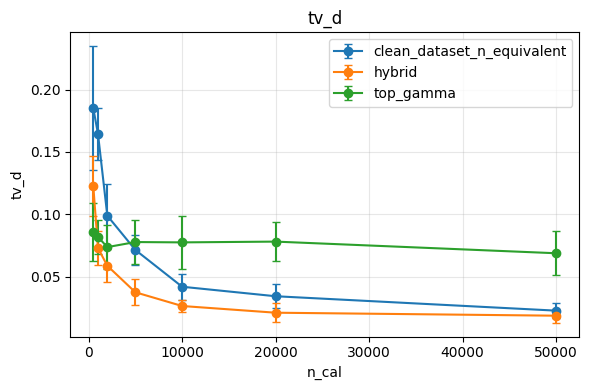

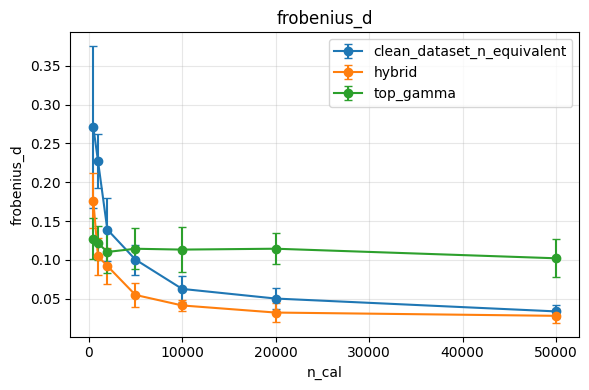

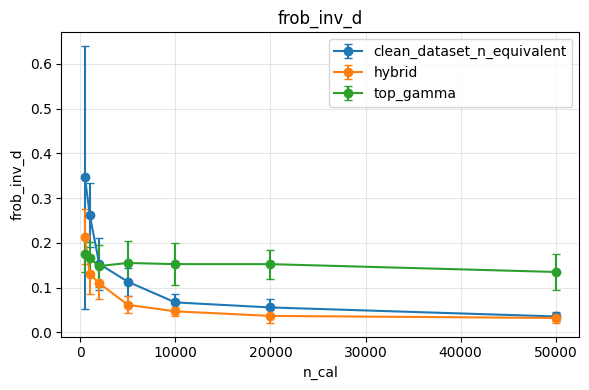

In [9]:
#summary = results.drop(columns=['seed']).groupby(['method', 'epsilon']).agg(['mean', 'std'])
summary = results.drop(columns=['seed']).replace({None: np.nan})
summary = summary.groupby(['method', 'n_cal']).agg(['mean', 'std'])
#summary = summary.groupby(['method', 'n_cal_eq']).agg(['mean', 'std'])
summary = summary.drop(index='clean_dataset', level='method')


metric_cols = ['tv_d', 'frobenius_d', 'frob_inv_d']

for metric in metric_cols:
    mean_vals = summary[metric]['mean'].unstack('method')
    std_vals  = summary[metric]['std'].unstack('method')

    plt.figure(figsize=(6, 4))
    
    for method in mean_vals.columns:
        plt.errorbar(
            mean_vals.index,
            mean_vals[method],
            yerr=std_vals[method],
            marker='o',
            linestyle='-',
            capsize=3,
            label=method
        )
    
    plt.title(f"{metric}")
    plt.xlabel("n_cal")
    #plt.xlabel("n_cal_eq")
    plt.ylabel(metric)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Commento

Ha senso ragionare in parallelo?

SET 1.

Set di esperimenti che, fissata una soglia gamma un po' a caso, controlla come si comportano gli stimatori considerati al variare del calibration sample size. Questo lo posso fare per diversi valori di gamma. Diciamo, che ne so, che provo 0.01, 0.03, 0.1, 0.2. Per ciascun gamma posso anche salvarmi l'accuratezza media del set di anchor points risultante.

Posso farmi venire in mente non solo questi stimatori totalmente non parametrici, ma anche degli stimatori parametrici. Tipo che do una forma parametrica alla T e mi invento una sorta di loss function per fare il fit? Posso inventarmi ad esempio uno stimatore parametrico per il randomized responde model. Questo può magari venire in due forme. Da un lato usando il metodo delle frequenze empiriche e dall'altro usando il point predictor che ho fittato sul training set. Questo fra l'latro lo potrei fare anche per il block randomized response model e per quello in cui c'è $\nu$ che non mi ricordo come si chiama.

Prova a ragionare dal punto di vista di un "cliente". Io ho un fottio di dati ma tutti sporchi. Ho bisogno di avere una ricetta con cui stimare la contaminazione. La ricetta anchor points potrebbe funzionare, ma devo poter dare delle garanzie. Le garanzie che vorrei poter dare sono:
a. Se hai un predittore abbastanza buono, riesci a stimare bene un set di anchor points
   Attenzione. Questa frase è sempre vera o ci sono dei modelli generativi per i quali individuare gli anchor points è più difficile? Ad esempio, se io riduco la separabilità delle classi, probabilmente non ha senso pensare agli anchor points.
   La questione qui mi sembra sempre la stessa. Come faccio a valutare la qualità degli anchor points?
   Se ho uno strumento per valutare la qualità degli anchor points che ho trovato, a quel 
b. Esiste un modo per capire che gamma utilizzare per individuare gli anchor points
c. Esiste un metodo migliore di un altro per, una volta individuati gli anchor points, ottenere una stima di T

SET 2.

Qui
Analizzo l'accura
Questo che cosa mi consente di capire. Mi consente di cogliere se +



Devo cominciare a pensare a che tipo di metriche di performance mi servano e a che tipo di esperimenti mi servano.
Forse a questo punto la cosa più immediata è sistemare il codice in modo che lo possa lanciare dal cluster con:
1. tanti possibili valori di n_cal
2. tanti possibili valori di n_train
3. tante possibili alternative per il predittore puntuale
4. una sequenza di valori di gamma
5. tante diverse configurazioni per generare i dati.

Qui però continuo a rientrare sempre nello stesso corto circuito.

Vediamo se riesco a tirarmene fuori.

Con un primo set di esperimenti io voglio arrivare a dire: assumendo che esistano dei punti di ancoraggio e di avere un predittore che funziona ok, ti mostro le performance degli stimatori di T considerati in termini dei KPI di cui abbiamo parlato.
Gli stimatori di T che metterei a confronto sono:
1. Lo stimatore Patrini et al (che non funziona)
2. Lo stimatore mio ibrido
3. Lo stimatore mio se avessi un oracle predictor degli anchor points (i.e. se tutti gli anchor points fossero effettivamente puliti)
4. La controparte parametrica per Patrini et al. (per il momento solo RRM)
5. La controparte parametrica dello stimatore mio ibrido. (per il momento solo RRM)
Questo lo farei vedere per diversi valori di gamma e mettendo accanto ad ogni gamma l'accuratezza media nel set anchor points, sia rispetto ai clean labels sia rispetto ai noisy labels.

Nell'asse delle ascisse cosa ci metto? Io ci metterei o n_cal (ma la performance del metodo con n_cal clean/noisy labels la metto? Oppure solo quella con n) oppure n_cal_equivalent. 
Queste performance le potrei testare per diversi modelli generativi dei dati, in particolare magari cambiando la separabilità delle classi? Oppure forse in prima battuta anche no, poi però magari posso far cambiare anche questo valore? Dopotutto basta semplicemente cambiare 
 
Con un secondo set di esperimenti vogliamo dare una ricetta per capire quando si ha individuato un set di anchor points che può essere utilizzato per fare una stima della matrice di contaminazione. Qui il problema mi sembra più difficile. Ok la rappresentazione

1. Il p In generale quello cheche a vari livelli di soglia e a divalori di .
Qui i predittori che dovrei confrontare sono 

La domanda che mi rimane aperta qui è: come faccio a capire quando la mia stima di T è abbastanza buona?



# Analysis on the accuracy of the set of anchor points

I move the threshold and see how the accuracy and the equivalent sample size changes.

I need to do this considering many possible predictors. Does it make sense though? What is the narrative here?

Quali parametri è utile far variare in questi esperimenti? Prima di chiudere questa sera posso migliorare il codice e buttare giù uno schema simulativo comodo e utile.

Che cosa mi interessa visualizzare? Iniziamo facile, per prima cosa mi importa guardare il comportamento dell'accuracy del predittore rispetto alla risposta vera e quella contaminata.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")

from cln import contamination
from third_party import arc

In [23]:
def tv_matrix_distance(P, Q):
    return np.mean([0.5 * np.sum(np.abs(P[i] - Q[i])) for i in range(P.shape[0])])

In [24]:
def evaluate_estimate(T, T_hat, verbose=False):
    T_norm = np.linalg.norm(T, 'fro')
    W = np.linalg.inv(T)
    Tinv_norm = np.linalg.norm(W, 'fro')

    # Method clean dataset
    tv_d = tv_matrix_distance(T.T, T_hat.T)
    frobenius_d = np.linalg.norm(T - T_hat, ord='fro')/T_norm

    try:
        W_hat = np.linalg.inv(T_hat)
        frob_inv_d = np.linalg.norm(W - W_hat, ord='fro')/Tinv_norm
    except np.linalg.LinAlgError:
        frob_inv_d = None

    res = {'tv_d':tv_d,
            'frobenius_d':frobenius_d,
            'frob_inv_d':frob_inv_d}
         
    if verbose:
        print('Total Variation Distance:            {:2.3%}'.format(tv_d))
        print('Fobrenius Distance:                  {:2.3%}'.format(frobenius_d))
        print('Fobrenius Distance of Inverses:      {:2.3%}'.format(frob_inv_d))

    return res

In [41]:
# Define experimental parameters
seed = 1
batch_size = 10
n_train = 5000
n_cal = 1000
gamma_vec = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

num_var = 20
K = 4
signal = 1.0
n_informative=np.maximum(1, int(num_var*0.5))
n_redundant=2
n_clusters_per_class=2

epsilon = 0.2

In [42]:
# Initialize black-box model
model_name = 'RFC'
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

In [43]:
# Describe the experiment
def run_experiment_accuracy(random_state):
    print("\nRunning experiment with random state {:d}...".format(random_state))
    sys.stdout.flush()

    res_new = []

    np.random.seed(random_state)
    # Generate a large data set
    X, Y = make_classification(n_samples=n_train+n_cal,
                                n_classes=K,
                                n_features=num_var,
                                n_informative=n_informative,
                                n_redundant=n_redundant,
                                n_clusters_per_class=n_clusters_per_class,
                                class_sep=signal,
                                random_state=random_state)

    # Define the contamination model
    T = (1-epsilon) * np.identity(K) + epsilon/K * np.ones((K,K))

    # Generate the contaminated labels
    contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+1)
    Yt = contamination_process.sample_labels(Y)

    # Separate data into training and calibration
    X_train, X_cal, Y_train, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, random_state=random_state+2)

    # Fit the point predictor on the training set
    black_box_pt = copy.deepcopy(black_box)
    black_box_pt.fit(X_train, Yt_train)

    # Estimate the probabilities on the calibration set
    p_hat_cal = black_box_pt.predict_proba(X_cal)
    if not isinstance(p_hat_cal, np.ndarray):
        p_hat_cal = np.asarray(p_hat_cal)
    _, K_out = p_hat_cal.shape
    assert K_out == K, f"black_box_pt returned {K_out} classes, expected {K}"

    for gamma in gamma_vec:
        ## Estimate the contamination process by identifying anchor points
        # Identify the set of anchor points with threshold gamma%
        anchor_points_list = []

        m = max(1, int(np.ceil(gamma * n_cal)))

        T_hat_hybrid = np.zeros((K, K), dtype=float)
        anchors_correct = 0
        anchors_correct_tilde = 0
        anchors_total = 0
        for l in range(K):
            scores_l = p_hat_cal[:, l]
            top_idx = np.argsort(scores_l)[::-1][:m]

            anchor_points_list.append(top_idx)

            # Use anchor points as true classes and then evaluate empirical frequencies
            if len(top_idx)>0:
                counts = np.bincount(Yt_cal[top_idx], minlength=K)
                T_hat_hybrid[:,l] = counts/len(top_idx)
            else:
                T_hat_hybrid[:, l] = np.ones(K) / K
        
            # Evaluate accuracy on identification of anchors
            Y_top = Y_cal[top_idx]
            Yt_top = Yt_cal[top_idx]
            anchors_correct += np.sum(Y_top == l)
            anchors_correct_tilde += np.sum(Yt_top == l)
            anchors_total   += len(top_idx)

        accuracy_gamma = anchors_correct/anchors_total
        accuracy_tilde_gamma = anchors_correct_tilde/anchors_total

        performances = evaluate_estimate(T, T_hat_hybrid)

        res_update = {'gamma': gamma,
                      'n_train': n_train,
                      'n_cal': n_cal,
                      'accuracy': accuracy_gamma,
                      'accuracy_tilde': accuracy_tilde_gamma}
        res_update.update(performances)
        res_update['seed'] = random_state
        
        res_new.append(res_update)

    res = pd.DataFrame(res_new)
    return res

In [44]:
# Run all experiments
all_results = []
for b in range(batch_size):
    res_b = run_experiment_accuracy(1000*seed*b+150)
    all_results.append(res_b)

results = pd.concat(all_results, ignore_index=True)


Running experiment with random state 150...

Running experiment with random state 1150...

Running experiment with random state 2150...

Running experiment with random state 3150...

Running experiment with random state 4150...

Running experiment with random state 5150...

Running experiment with random state 6150...

Running experiment with random state 7150...

Running experiment with random state 8150...

Running experiment with random state 9150...


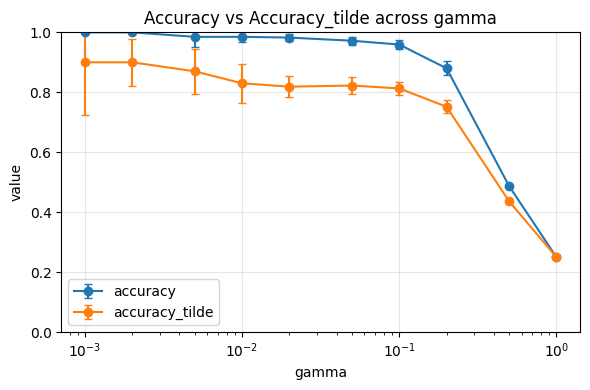

In [45]:
summary = results.groupby(['gamma']).agg(['mean', 'std'])

metric_cols = ['accuracy', 'accuracy_tilde']
colors = ['tab:blue', 'tab:orange']

plt.figure(figsize=(6, 4))

for metric, col in zip(metric_cols, colors):
    mean_vals = summary[metric]['mean']
    std_vals  = summary[metric]['std']

    plt.errorbar(
        mean_vals.index,
        mean_vals.values,
        yerr=std_vals.values,
        marker='o',
        linestyle='-',
        capsize=3,
        color=col,
        label=metric
    )
plt.xscale("log") 
plt.ylim(0, 1)
plt.xlabel("gamma")
plt.ylabel("value")
plt.title("Accuracy vs Accuracy_tilde across gamma")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

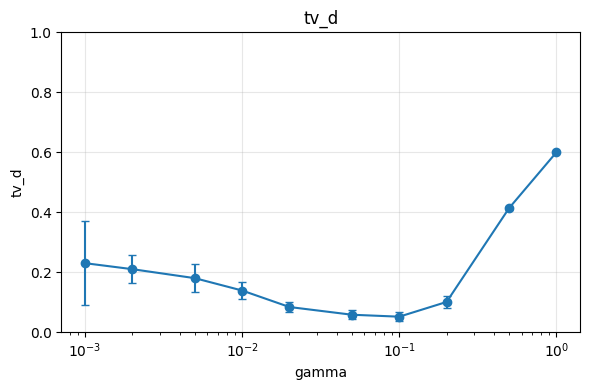

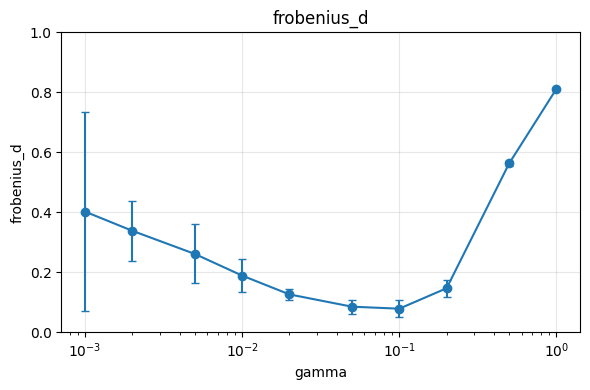

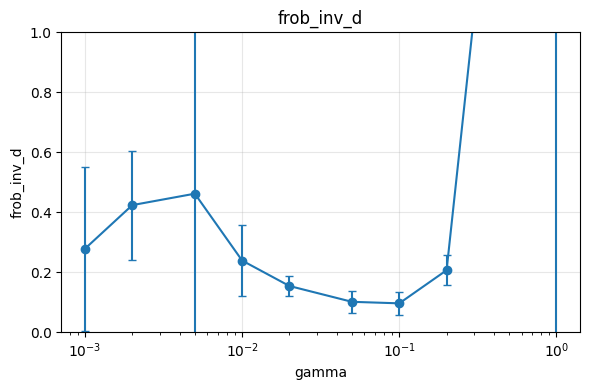

In [46]:
metric_cols = ['tv_d', 'frobenius_d', 'frob_inv_d']

for metric in metric_cols:
    mean_vals = summary[metric]['mean']
    std_vals  = summary[metric]['std']

    plt.figure(figsize=(6, 4))
    
    plt.errorbar(
            mean_vals.index,
            mean_vals.values,
            yerr=std_vals.values,
            marker='o',
            linestyle='-',
            capsize=3
        )
        
    plt.xscale("log")
    plt.ylim(0, 1)
    plt.title(f"{metric}")
    plt.xlabel("gamma")
    plt.ylabel(metric)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Ok, individuare un minimo rispetto a gamma è bello. Io quello che mi aspetto è che, mentre il plot sulla accuracy non cambia, questi plot dei KPI dello stimatore di T cambiano rispetto al calibration sample size.

Ok. Io quello che devo fare è palesemente individuare un criterio per la scelta di gamma.
Di sicuro non posso controllare l'accuratezza rispetto ai label puliti. Posso invece pensare di individuare una soglia guardando l'accuratezza rispetto ai label contaminati.

Secondo me adesso devo fare un sacco di lavoro.

Mi aspetto che il plot che ho fatto sopra non cambi al cambiare del numero di calibration points. Mi aspetto invece che cambi nel momento in cui cambiano questi tre fattori:

a. Il modello di contaminazione
b. La qualità del point predictor --> sia proprio in termini di forma del predittore che proprio in termini di numerosità del training set
c. Il modello generativo dei dati (?)
d. Il numero di classi?

Posso fare prima degli esperimenti semplici qui e poi scrivere giù il codice per fare esperimenti estensivi. Prima di farlo sarebbe molto opportuno avere bene in mente lo story telling. Che cosa voglio trovare? Cosa voglio dimostrare? Che storia voglio raccontare?

1. Controllare come cambia questo plot al variare di epsilon (al variare cioè del livello di contaminazione)
2. Posso controllare cosa succede anche al variare del modello di contaminazione stesso
3. Posso guardare che succede anche quando mi invento un modello di contaminazione a caso.
4. Poi devo guardare come cambiano le cose quando ho un predittore che fa cagare. Posso o inventarmene uno pietoso oppure ridurre il training set.
5. Prima di individuare la soglia, devo controllare che cosa succede alla stima di T quando il set di anchor points peggiora.


In teoria lo step finale di tutto questo è arrivare ad avere un algoritmo completo in cui posso: a. individuare gli anchor points, b. definire la soglia, c. usare il metodo ibrido per stimare la contaminazione, d. plug the estimated T in the adaptive method.
Dopo aver presentato tutto questo algoritmo devo essere ben sicura che tutto abbia senso. Ci sono dei punti in cui faccio delle assunzioni che non hanno senso? Creo dei corto circuiti? La narrazione ha senso dall'inizio alla fine? Il sistema anchor points, quando viene messo in crisi? Ci sono delle configurazioni dei dati che possono mandarmi tutto in vacca?


Stasera prima di andare a letto posso riascoltare il meeting di venerdì scorso e 1. spararmi, 2. controllare se mi torna tutto. Non so bene quando posso mettermi lì a fare quei conti di merda sull'accuracy ma boh forse per ora non sono la mia priorità (?). Cioè ha comunque senso prima controllare in modo empirico come gira la vita.

PENSIERO PROBABILMENTE MOLTO STUPIDO

Forse quello che posso fare è controllare la qualità della stima di T al variare dell'accuracy. Se individuo una soglia di accuracy che mi va bene, a quel punto posso ... no questa mi sembra una cagata perché
Però forse in effetti è vero che ai grafici sotto dovrei affiancare anche un plot con l'andamento della qualità di T al variare della soglia. In questo modo ho più info a disposizione per individuare una soglia sensata.

PERò C'é UN PERò! Mentre posso immaginare che le due curve di accuracy non subiscano variazioni al variare di n_cal, mi aspetto che invece la qualità di T cambi molto al cambiare di n_cal, a parità di soglia gamma. Questo è un punto importante.

Ragiona... qui c'è qualcosa che non mi torna.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")

from cln import contamination
from third_party import arc

In [14]:
# Define experimental parameters
seed = 1
batch_size = 10
n_train = 5000
n_cal = 5000
gamma_vec = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

num_var = 20
K = 5
signal = 1.0
n_informative=np.maximum(1, int(num_var*0.5))
n_redundant=2
n_clusters_per_class=2

epsilon = 0.2

In [19]:
# Initialize black-box model
model_name = 'SVC'
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
elif model_name == 'MF':
    black_box = DummyClassifier(strategy="most_frequent")
elif model_name == 'SRC':
    black_box = DummyClassifier(strategy="stratified")
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

In [20]:
# Describe the experiment
def run_experiment_accuracy(random_state):
    print("\nRunning experiment with random state {:d}...".format(random_state))
    sys.stdout.flush()

    res_new = []

    np.random.seed(random_state)
    # Generate a large data set
    X, Y = make_classification(n_samples=n_train+n_cal,
                                n_classes=K,
                                n_features=num_var,
                                n_informative=n_informative,
                                n_redundant=n_redundant,
                                n_clusters_per_class=n_clusters_per_class,
                                class_sep=signal,
                                random_state=random_state)

    # Define the contamination model
    T = (1-epsilon) * np.identity(K) + epsilon/K * np.ones((K,K))

    # Generate the contaminated labels
    contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+1)
    Yt = contamination_process.sample_labels(Y)

    # Separate data into training and calibration
    X_train, X_cal, Y_train, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, random_state=random_state+2)

    # Fit the point predictor on the training set
    black_box_pt = copy.deepcopy(black_box)
    black_box_pt.fit(X_train, Yt_train)

    # Estimate the probabilities on the calibration set
    p_hat_cal = black_box_pt.predict_proba(X_cal)
    if not isinstance(p_hat_cal, np.ndarray):
        p_hat_cal = np.asarray(p_hat_cal)
    _, K_out = p_hat_cal.shape
    assert K_out == K, f"black_box_pt returned {K_out} classes, expected {K}"

    for gamma in gamma_vec:
        ## Estimate the contamination process by identifying anchor points
        # Identify the set of anchor points with threshold gamma%
        anchor_points_list = []

        m = max(1, int(np.ceil(gamma * n_cal)))

        T_hat_top = np.zeros((K, K), dtype=float)
        T_hat_hybrid = np.zeros((K, K), dtype=float)
        anchors_correct = 0
        anchors_correct_tilde = 0
        anchors_total = 0
        for l in range(K):
            scores_l = p_hat_cal[:, l]
            top_idx = np.argsort(scores_l)[::-1][:m]

            anchor_points_list.append(top_idx)

            # Method of Patrini at al. 2017
            col_T_hat = p_hat_cal[top_idx, :].mean(axis=0)
            T_hat_top[:, l] = col_T_hat/np.sum(col_T_hat)

            # Use anchor points as true classes and then evaluate empirical frequencies
            if len(top_idx)>0:
                counts = np.bincount(Yt_cal[top_idx], minlength=K)
                T_hat_hybrid[:,l] = counts/len(top_idx)
            else:
                T_hat_hybrid[:, l] = np.ones(K) / K
        
            # Evaluate accuracy on identification of anchors
            Y_top = Y_cal[top_idx]
            Yt_top = Yt_cal[top_idx]
            anchors_correct += np.sum(Y_top == l)
            anchors_correct_tilde += np.sum(Yt_top == l)
            anchors_total   += len(top_idx)

        accuracy_gamma = anchors_correct/anchors_total
        accuracy_tilde_gamma = anchors_correct_tilde/anchors_total

        res_update = {'gamma': gamma,
                      'n_train': n_train,
                      'n_cal': n_cal,
                      'accuracy': accuracy_gamma,
                      'accuracy_tilde': accuracy_tilde_gamma,
                      'seed': random_state}
        
        res_new.append(res_update)

    res = pd.DataFrame(res_new)
    return res

In [21]:
# Run all experiments
all_results = []
for b in range(batch_size):
    res_b = run_experiment_accuracy(1000*seed*b+150)
    all_results.append(res_b)

results = pd.concat(all_results, ignore_index=True)


Running experiment with random state 150...

Running experiment with random state 1150...

Running experiment with random state 2150...

Running experiment with random state 3150...

Running experiment with random state 4150...

Running experiment with random state 5150...

Running experiment with random state 6150...

Running experiment with random state 7150...

Running experiment with random state 8150...

Running experiment with random state 9150...


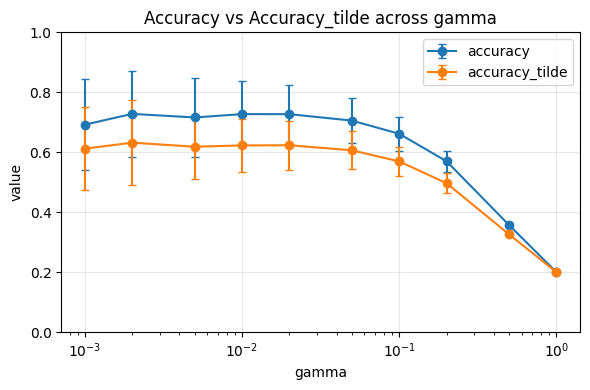

In [22]:
summary = results.groupby(['gamma']).agg(['mean', 'std'])

metric_cols = ['accuracy', 'accuracy_tilde']
colors = ['tab:blue', 'tab:orange']

plt.figure(figsize=(6, 4))

for metric, col in zip(metric_cols, colors):
    mean_vals = summary[metric]['mean']
    std_vals  = summary[metric]['std']

    plt.errorbar(
        mean_vals.index,
        mean_vals.values,
        yerr=std_vals.values,
        marker='o',
        linestyle='-',
        capsize=3,
        color=col,
        label=metric
    )
plt.xscale("log") 
plt.ylim(0, 1)
plt.xlabel("gamma")
plt.ylabel("value")
plt.title("Accuracy vs Accuracy_tilde across gamma")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
